# Smulemates - Singing Style Recommendation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

import librosa.display

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import heapq

## Feature Extraction

In [2]:
files=os.listdir('Data/Vocal_Balanced/audio/')

In [ ]:
#Load audio into librosa to extract MFCC featurs.  Created a good_files and bad_files lists.
#Good_files are necessary in order so that the indices of the performance keys match the MFCC rows.
#Bad_files are those that did not have singing/cut short.

mfcc_all = []
good_files = []
bad_files = []
i=0
for file in files:
    file_path = 'Data/Vocal_Balanced/audio/' + file
    try:
        y, sr = librosa.load(file_path,offset=67,duration=5)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
        mfcc_r = mfccs.reshape(1,-1)
        mfcc_r = mfcc_r[0].tolist()
        mfcc_all.append(mfcc_r)
        good_files.append(file)
    except:
        print('Failed at '+file)
        bad_files.append(file)
        pass
    i+=1
    print(i)

## Creating dataframes

In [29]:
good_files_df = pd.DataFrame(good_files)

In [30]:
good_files_df.columns=['perf_key']

In [10]:
good_files_df.shape

(24669, 1)

In [13]:
bad_files_df = pd.DataFrame(bad_files)

In [14]:
bad_files_df.shape

(205, 1)

In [11]:
mfcc_df = pd.DataFrame(mfcc_all)

In [106]:
mfcc_df.to_pickle("mfcc_df_original.pickle")

In [107]:
good_files_df.to_pickle("good_files_df.pickle")

In [108]:
bad_files_df.to_pickle("bad_files_df.pickle")

In [12]:
mfcc_df.shape

(24669, 2592)

In [63]:
mfcc_df

,0,1,2,3,4,5,6,7,8,9,...,2582,2583,2584,2585,2586,2587,2588,2589,2590,2591
0,-588.620911,-588.451904,-578.602417,-573.562134,-588.381714,-588.077515,-585.073364,-587.489014,-588.873535,-588.621948,...,-11.550845,-9.841369,-15.376024,-19.152637,-14.321207,-14.220863,-15.966101,-10.317374,-10.220319,-5.223012
1,-219.070877,-217.684830,-241.405624,-257.286682,-255.101883,-259.276855,-292.216064,-303.701935,-288.007141,-295.294342,...,12.878452,10.318534,13.328442,9.621280,-1.469968,-5.348037,-6.184847,-1.001535,-6.351072,-7.358464
2,-343.493866,-274.836792,-252.033096,-282.952301,-307.492767,-307.294769,-315.247925,-314.961700,-304.421570,-296.069397,...,-24.003353,-17.387880,-7.215163,-5.649278,0.079726,2.903812,4.690093,13.604004,4.343108,-12.381579
3,-108.030556,-103.901924,-108.419930,-100.035065,-104.944138,-117.052666,-138.181351,-141.332748,-133.507050,-124.981453,...,5.891233,11.579876,12.413626,11.458061,8.186522,-3.147126,-8.128942,-12.006811,-9.240435,-8.291071
4,-205.468338,-216.758377,-246.439117,-241.021622,-243.774796,-248.783508,-249.980484,-253.076080,-265.016266,-324.675201,...,-15.876646,-15.199093,-14.095329,-14.361534,-16.145386,-15.597174,-14.154770,-13.166204,-12.204078,-6.526006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24664,-500.295807,-497.149323,-501.358978,-504.870941,-505.977112,-508.041534,-511.917938,-508.690125,-511.130035,-511.570740,...,-6.795150,-2.933717,-3.948601,-7.506539,-4.153156,-1.598176,-7.861636,-15.696771,-24.773785,-16.922180
24665,-55.919247,-90.002525,-171.443466,-171.744446,-161.659103,-186.333862,-265.314850,-327.954254,-326.338745,-317.448151,...,-0.757022,2.805445,1.270979,-1.185890,1.175275,-5.969260,-5.694136,4.117299,6.317298,1.022254
24666,-324.466888,-311.731964,-313.369019,-314.942596,-316.212036,-321.465210,-317.943848,-316.217804,-324.585602,-322.315552,...,-12.809868,-21.142540,-17.230062,-10.842885,-11.019097,-16.966488,-16.730244,-14.594507,-7.938159,1.869567
24667,-480.620697,-477.691101,-478.799591,-483.049377,-489.150482,-464.857605,-402.276947,-364.701416,-349.182739,-352.467743,...,-8.158308,-12.467234,-8.095827,-3.533216,-6.210123,-14.787035,-12.014723,-15.212805,-22.313826,-17.780716


In [33]:
#Merge good_files and mfcc_df to add perf_key column at the end

mfcc_file = mfcc_df.merge(good_files_df, right_index=True, left_index=True)

In [34]:
mfcc_file

,0,1,2,3,4,5,6,7,8,9,...,2583,2584,2585,2586,2587,2588,2589,2590,2591,perf_key
0,-588.620911,-588.451904,-578.602417,-573.562134,-588.381714,-588.077515,-585.073364,-587.489014,-588.873535,-588.621948,...,-9.841369,-15.376024,-19.152637,-14.321207,-14.220863,-15.966101,-10.317374,-10.220319,-5.223012,266262844_833109990.m4a
1,-219.070877,-217.684830,-241.405624,-257.286682,-255.101883,-259.276855,-292.216064,-303.701935,-288.007141,-295.294342,...,10.318534,13.328442,9.621280,-1.469968,-5.348037,-6.184847,-1.001535,-6.351072,-7.358464,406062012_1289105907.m4a
2,-343.493866,-274.836792,-252.033096,-282.952301,-307.492767,-307.294769,-315.247925,-314.961700,-304.421570,-296.069397,...,-17.387880,-7.215163,-5.649278,0.079726,2.903812,4.690093,13.604004,4.343108,-12.381579,382757996_1391701608.m4a
3,-108.030556,-103.901924,-108.419930,-100.035065,-104.944138,-117.052666,-138.181351,-141.332748,-133.507050,-124.981453,...,11.579876,12.413626,11.458061,8.186522,-3.147126,-8.128942,-12.006811,-9.240435,-8.291071,548780582_1359815083.m4a
4,-205.468338,-216.758377,-246.439117,-241.021622,-243.774796,-248.783508,-249.980484,-253.076080,-265.016266,-324.675201,...,-15.199093,-14.095329,-14.361534,-16.145386,-15.597174,-14.154770,-13.166204,-12.204078,-6.526006,204624671_865845470.m4a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24664,-500.295807,-497.149323,-501.358978,-504.870941,-505.977112,-508.041534,-511.917938,-508.690125,-511.130035,-511.570740,...,-2.933717,-3.948601,-7.506539,-4.153156,-1.598176,-7.861636,-15.696771,-24.773785,-16.922180,938788819_792156904.m4a
24665,-55.919247,-90.002525,-171.443466,-171.744446,-161.659103,-186.333862,-265.314850,-327.954254,-326.338745,-317.448151,...,2.805445,1.270979,-1.185890,1.175275,-5.969260,-5.694136,4.117299,6.317298,1.022254,1232569264_1382173335.m4a
24666,-324.466888,-311.731964,-313.369019,-314.942596,-316.212036,-321.465210,-317.943848,-316.217804,-324.585602,-322.315552,...,-21.142540,-17.230062,-10.842885,-11.019097,-16.966488,-16.730244,-14.594507,-7.938159,1.869567,417369077_1021842231.m4a
24667,-480.620697,-477.691101,-478.799591,-483.049377,-489.150482,-464.857605,-402.276947,-364.701416,-349.182739,-352.467743,...,-12.467234,-8.095827,-3.533216,-6.210123,-14.787035,-12.014723,-15.212805,-22.313826,-17.780716,729835288_1383966974.m4a


In [35]:
#Removed rows with NA's

mfcc_file_nona=mfcc_file.dropna()

In [66]:
#Re-index after dropping rows with NA's

mfcc_rindex=mfcc_file_nona.reset_index(drop=True)

In [67]:
mfcc_rindex

,0,1,2,3,4,5,6,7,8,9,...,2583,2584,2585,2586,2587,2588,2589,2590,2591,perf_key
0,-588.620911,-588.451904,-578.602417,-573.562134,-588.381714,-588.077515,-585.073364,-587.489014,-588.873535,-588.621948,...,-9.841369,-15.376024,-19.152637,-14.321207,-14.220863,-15.966101,-10.317374,-10.220319,-5.223012,266262844_833109990.m4a
1,-219.070877,-217.684830,-241.405624,-257.286682,-255.101883,-259.276855,-292.216064,-303.701935,-288.007141,-295.294342,...,10.318534,13.328442,9.621280,-1.469968,-5.348037,-6.184847,-1.001535,-6.351072,-7.358464,406062012_1289105907.m4a
2,-343.493866,-274.836792,-252.033096,-282.952301,-307.492767,-307.294769,-315.247925,-314.961700,-304.421570,-296.069397,...,-17.387880,-7.215163,-5.649278,0.079726,2.903812,4.690093,13.604004,4.343108,-12.381579,382757996_1391701608.m4a
3,-108.030556,-103.901924,-108.419930,-100.035065,-104.944138,-117.052666,-138.181351,-141.332748,-133.507050,-124.981453,...,11.579876,12.413626,11.458061,8.186522,-3.147126,-8.128942,-12.006811,-9.240435,-8.291071,548780582_1359815083.m4a
4,-205.468338,-216.758377,-246.439117,-241.021622,-243.774796,-248.783508,-249.980484,-253.076080,-265.016266,-324.675201,...,-15.199093,-14.095329,-14.361534,-16.145386,-15.597174,-14.154770,-13.166204,-12.204078,-6.526006,204624671_865845470.m4a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24615,-500.295807,-497.149323,-501.358978,-504.870941,-505.977112,-508.041534,-511.917938,-508.690125,-511.130035,-511.570740,...,-2.933717,-3.948601,-7.506539,-4.153156,-1.598176,-7.861636,-15.696771,-24.773785,-16.922180,938788819_792156904.m4a
24616,-55.919247,-90.002525,-171.443466,-171.744446,-161.659103,-186.333862,-265.314850,-327.954254,-326.338745,-317.448151,...,2.805445,1.270979,-1.185890,1.175275,-5.969260,-5.694136,4.117299,6.317298,1.022254,1232569264_1382173335.m4a
24617,-324.466888,-311.731964,-313.369019,-314.942596,-316.212036,-321.465210,-317.943848,-316.217804,-324.585602,-322.315552,...,-21.142540,-17.230062,-10.842885,-11.019097,-16.966488,-16.730244,-14.594507,-7.938159,1.869567,417369077_1021842231.m4a
24618,-480.620697,-477.691101,-478.799591,-483.049377,-489.150482,-464.857605,-402.276947,-364.701416,-349.182739,-352.467743,...,-12.467234,-8.095827,-3.533216,-6.210123,-14.787035,-12.014723,-15.212805,-22.313826,-17.780716,729835288_1383966974.m4a


In [69]:
#Removing perf_key column for next step (dimensionality reduction)

mfcc_nona=mfcc_rindex.drop(['perf_key'],axis=1)

In [70]:
mfcc_nona

,0,1,2,3,4,5,6,7,8,9,...,2582,2583,2584,2585,2586,2587,2588,2589,2590,2591
0,-588.620911,-588.451904,-578.602417,-573.562134,-588.381714,-588.077515,-585.073364,-587.489014,-588.873535,-588.621948,...,-11.550845,-9.841369,-15.376024,-19.152637,-14.321207,-14.220863,-15.966101,-10.317374,-10.220319,-5.223012
1,-219.070877,-217.684830,-241.405624,-257.286682,-255.101883,-259.276855,-292.216064,-303.701935,-288.007141,-295.294342,...,12.878452,10.318534,13.328442,9.621280,-1.469968,-5.348037,-6.184847,-1.001535,-6.351072,-7.358464
2,-343.493866,-274.836792,-252.033096,-282.952301,-307.492767,-307.294769,-315.247925,-314.961700,-304.421570,-296.069397,...,-24.003353,-17.387880,-7.215163,-5.649278,0.079726,2.903812,4.690093,13.604004,4.343108,-12.381579
3,-108.030556,-103.901924,-108.419930,-100.035065,-104.944138,-117.052666,-138.181351,-141.332748,-133.507050,-124.981453,...,5.891233,11.579876,12.413626,11.458061,8.186522,-3.147126,-8.128942,-12.006811,-9.240435,-8.291071
4,-205.468338,-216.758377,-246.439117,-241.021622,-243.774796,-248.783508,-249.980484,-253.076080,-265.016266,-324.675201,...,-15.876646,-15.199093,-14.095329,-14.361534,-16.145386,-15.597174,-14.154770,-13.166204,-12.204078,-6.526006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24615,-500.295807,-497.149323,-501.358978,-504.870941,-505.977112,-508.041534,-511.917938,-508.690125,-511.130035,-511.570740,...,-6.795150,-2.933717,-3.948601,-7.506539,-4.153156,-1.598176,-7.861636,-15.696771,-24.773785,-16.922180
24616,-55.919247,-90.002525,-171.443466,-171.744446,-161.659103,-186.333862,-265.314850,-327.954254,-326.338745,-317.448151,...,-0.757022,2.805445,1.270979,-1.185890,1.175275,-5.969260,-5.694136,4.117299,6.317298,1.022254
24617,-324.466888,-311.731964,-313.369019,-314.942596,-316.212036,-321.465210,-317.943848,-316.217804,-324.585602,-322.315552,...,-12.809868,-21.142540,-17.230062,-10.842885,-11.019097,-16.966488,-16.730244,-14.594507,-7.938159,1.869567
24618,-480.620697,-477.691101,-478.799591,-483.049377,-489.150482,-464.857605,-402.276947,-364.701416,-349.182739,-352.467743,...,-8.158308,-12.467234,-8.095827,-3.533216,-6.210123,-14.787035,-12.014723,-15.212805,-22.313826,-17.780716


In [71]:
mfcc_nona.shape

(24620, 2592)

## Dimensionality Reduction

In [72]:
scaler=StandardScaler()
mfcc_df_rescaled=scaler.fit_transform(mfcc_nona)

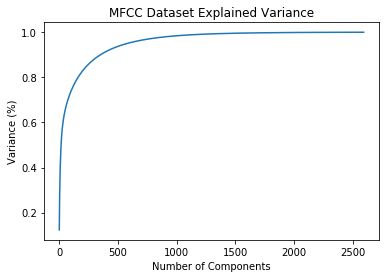

In [83]:
pca = PCA().fit(mfcc_df_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('MFCC Dataset Explained Variance')
plt.show()

In [73]:
pca=PCA(n_components=1000, random_state=3)
mfcc_df_r_pca=pca.fit_transform(mfcc_df_rescaled)

# Content-Based Recommendation - Cosine Similarity

In [84]:
def getSimilarN(row = None, N=4, matrix=mfcc_df_r_pca):
        obs=matrix.shape[0]
        
        if row == None:
            sampled_row = np.random.randint(0, obs)
        else:
            sampled_row = row
        assert sampled_row <= obs
        
        center = matrix[sampled_row]
        
        dist = np.array([1-distance.cosine(row, center) for row in matrix])
        SimilarNIndices = heapq.nlargest(N, range(len(dist)), dist.take)
        
        return SimilarNIndices, dist[SimilarNIndices]

In [93]:
#Returning top 3 performances with highest cosine similarity as performance at index 4343

getSimilarN(row=4343,matrix=mfcc_df_r_pca)

([4343, 23186, 16421, 21877],
 array([1.        , 0.65752972, 0.6076038 , 0.60466575]))

In [99]:
mfcc_rindex.iloc[4343]

0                          -253.775
1                          -277.767
2                          -334.424
3                          -340.521
4                          -340.776
                     ...           
2588                       -41.0126
2589                       -36.0511
2590                       -19.1404
2591                        -15.149
perf_key    36299649_1040046003.m4a
Name: 4343, Length: 2593, dtype: object

In [94]:
mfcc_rindex.iloc[23186]

0                            -152.449
1                            -176.414
2                            -243.208
3                            -272.411
4                            -304.209
                      ...            
2588                         -31.9287
2589                         -29.0184
2590                         -24.8176
2591                         -27.9333
perf_key    1197975077_1298364676.m4a
Name: 23186, Length: 2593, dtype: object

In [95]:
mfcc_rindex.iloc[16421]

0                            -204.917
1                            -226.954
2                            -276.488
3                            -278.596
4                            -288.598
                      ...            
2588                         -27.0232
2589                         -26.3176
2590                         -18.8231
2591                         -19.9234
perf_key    1088211785_1090524433.m4a
Name: 16421, Length: 2593, dtype: object

In [96]:
mfcc_rindex.iloc[21877]

0                           -173.235
1                           -193.278
2                           -249.333
3                           -256.885
4                           -299.779
                      ...           
2588                        -20.7234
2589                        -21.8868
2590                        -15.6485
2591                        -10.8113
perf_key    431357134_1272078318.m4a
Name: 21877, Length: 2593, dtype: object